<a href="https://colab.research.google.com/github/VaishnaviMudaliar/deep-learning/blob/main/GAN_implementation_using_dense_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries

from numpy import zeros , ones , expand_dims , asarray
from numpy.random import randn , randint
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.models import Model , load_model
from keras.layers import Input , Dense , Reshape , Flatten
from keras.layers import Conv2D , Conv2DTranspose , Concatenate
from keras.layers import LeakyReLU , Dropout , Embedding
from keras.layers import BatchNormalization , Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam , RMSprop , SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

In [2]:
# Loading the dataset
(X_train,_),(_,_) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
X_train = X_train.astype(np.float32)/ 127.5 - 1
X_train = np.expand_dims(X_train , axis= 3)
print(X_train.shape)

(60000, 28, 28, 1)


In [4]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [31]:
def generate_real_samples(X_train , n_samples):
  ix = randint(0 , X_train.shape[0] , n_samples)
  X = X_train[ix]
  y = ones((n_samples , 1))
  return X,y

In [6]:
def generate_fake_samples(generator , latent_dim , n_samples):
  z_input = generate_latent_points(latent_dim , n_samples)
  images = generator.predict(z_input)
  y = zeros((n_samples , 1))
  return images , y

In [7]:
def summarize_performance(step , g_model , latent_dim , n_samples = 100):
  X , _ = generate_fake_samples(g_model , latent_dim , n_samples)
  X = (X+1)/2.0
  for i in range(100):
    pyplot.subplot(10 , 10 , 1+i)
    pyplot.axis('off')
    pyplot.imshow(X[i,:,:,0],cmap = 'gray_r')
  filename2 = 'model_%04d.h5'% (step+1)
  g_model.save(filename2)
  print('Saved : %s' % (filename2))

In [37]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(int(sqrt(n_examples)),int(sqrt(n_examples)), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

# Model Building

In [16]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [12]:
discriminator = define_discriminator()

In [17]:
def define_generator(latent_dim) :
  init = RandomNormal(stddev= 0.02)
  in_lat = Input(shape = (latent_dim,))
  gen = Dense(256 , kernel_initializer=init)(in_lat)
  gen = LeakyReLU(alpha = 0.2)(gen)
  gen = Dense(512 , kernel_initializer=init)(gen)
  gen = LeakyReLU(alpha = 0.2)(gen)
  gen = Dense(28 * 28 * 1, kernel_initializer= init)(gen)
  out_layer = Activation('tanh')(gen)
  out_layer = Reshape((28,28,1))(gen)
  model = Model(in_lat , out_layer)
  return model
generator = define_generator(100)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [18]:
def define_gan(g_model , d_model):
  d_model.trainable = False
  gan_output = d_model(g_model.output)
  model = Model(g_model.input , gan_output)
  opt= Adam(learning_rate = 0.0002 , beta_1= 0.5)
  model.compile(loss = 'binary_crossentropy' , optimizer = opt , metrics = ['accuracy'])
  return model

In [19]:
gan_model = define_gan(generator , discriminator)

# Model Training

In [32]:
def train(g_model , d_model , gan_model , X_train , latent_dim , n_epochs = 100 , n_batch = 64):
  bat_per_epo = int(X_train.shape[0]/n_batch)
  n_steps = bat_per_epo * n_epochs
  for i in range (n_steps) :
    X_real , y_real = generate_real_samples(X_train , n_batch)
    d_loss_r , d_acc_r = d_model.train_on_batch(X_real , y_real)
    X_fake , y_fake = generate_fake_samples(g_model , latent_dim , n_batch)
    d_loss_f , d_acc_f = d_model.train_on_batch(X_fake , y_fake)
    z_input = generate_latent_points(latent_dim , n_batch)
    y_gan = ones((n_batch ,1))
    g_loss,g_acc = gan_model.train_on_batch(z_input , y_gan)
    print('>%d , dr[%.3f , %.3f] ,df[%.3f , %.3f],g[%.3f , %.3f]' % (i+1 , d_loss_r , d_acc_r , d_loss_f , d_acc_f , g_loss ,g_acc))
    if (i+1) % (bat_per_epo *1) == 0:
      summarize_performance(i , g_model,latent_dim)

2/2 [==============================] - 0s 8ms/step
>1 , dr[0.916 , 0.328] ,df[0.731 , 0.000],g[0.665 , 1.000]
2/2 [==============================] - 0s 9ms/step
>2 , dr[0.000 , 1.000] ,df[0.743 , 0.000],g[0.672 , 1.000]
2/2 [==============================] - 0s 6ms/step
>3 , dr[0.000 , 1.000] ,df[0.728 , 0.000],g[0.693 , 0.516]
2/2 [==============================] - 0s 7ms/step
>4 , dr[0.000 , 1.000] ,df[0.700 , 0.312],g[0.724 , 0.000]
2/2 [==============================] - 0s 8ms/step
>5 , dr[0.000 , 1.000] ,df[0.668 , 0.984],g[0.776 , 0.000]
2/2 [==============================] - 0s 7ms/step
>6 , dr[0.001 , 1.000] ,df[0.615 , 1.000],g[0.869 , 0.000]
2/2 [==============================] - 0s 13ms/step
>7 , dr[0.000 , 1.000] ,df[0.547 , 1.000],g[1.014 , 0.000]
2/2 [==============================] - 0s 7ms/step
>8 , dr[0.022 , 1.000] ,df[0.527 , 1.000],g[1.007 , 0.000]
2/2 [==============================] - 0s 9ms/step
>9 , dr[0.000 , 1.000] ,df[0.504 , 1.000],g[1.126 , 0.000]
2/2 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved : model_0937.h5
2/2 [==============================] - 0s 10ms/step
>938 , dr[0.351 , 0.828] ,df[0.173 , 1.000],g[2.383 , 0.000]
2/2 [==============================] - 0s 8ms/step
>939 , dr[0.206 , 0.875] ,df[0.197 , 0.984],g[2.609 , 0.000]
2/2 [==============================] - 0s 9ms/step
>940 , dr[0.253 , 0.891] ,df[0.159 , 1.000],g[2.543 , 0.000]
2/2 [==============================] - 0s 8ms/step
>941 , dr[0.450 , 0.781] ,df[0.448 , 0.875],g[2.508 , 0.000]
2/2 [==============================] - 0s 7ms/step
>942 , dr[0.186 , 0.922] ,df[0.146 , 0.984],g[2.813 , 0.000]
2/2 [==============================] - 0s 9ms/step
>943 , dr[0.426 , 0.812] ,df[0.155 , 0.984],g[2.475 , 0.000]
2/2 [==============================] - 0s 8ms/step
>944 , dr[0.505 , 0.781] ,df[0.229 , 0.969],g[2.008 , 0.000]
2/2 [==============================] - 0s 10ms/step
>945 , dr[0.267 , 0.859] ,df[0.170 , 1.000],g[2.145 , 0.000]
2/2 [==============================] - 0s 10ms/step
>946 , dr[0.305 , 0.828] ,df

Saved : model_1874.h5
2/2 [==============================] - 0s 8ms/step
>1875 , dr[0.306 , 0.875] ,df[0.493 , 0.750],g[2.858 , 0.000]
2/2 [==============================] - 0s 8ms/step
>1876 , dr[0.322 , 0.844] ,df[0.181 , 0.984],g[2.776 , 0.016]
2/2 [==============================] - 0s 8ms/step
>1877 , dr[0.388 , 0.797] ,df[0.316 , 0.906],g[2.117 , 0.047]
2/2 [==============================] - 0s 8ms/step
>1878 , dr[0.192 , 0.906] ,df[0.401 , 0.875],g[2.543 , 0.016]
2/2 [==============================] - 0s 8ms/step
>1879 , dr[0.313 , 0.844] ,df[0.453 , 0.828],g[2.376 , 0.016]
2/2 [==============================] - 0s 7ms/step
>1880 , dr[0.424 , 0.797] ,df[0.297 , 0.922],g[2.283 , 0.031]
2/2 [==============================] - 0s 6ms/step
>1881 , dr[0.409 , 0.781] ,df[0.389 , 0.844],g[2.154 , 0.047]
2/2 [==============================] - 0s 6ms/step
>1882 , dr[0.219 , 0.875] ,df[0.192 , 0.969],g[2.302 , 0.016]
2/2 [==============================] - 0s 10ms/step
>1883 , dr[0.361 , 0.8

Saved : model_2811.h5
2/2 [==============================] - 0s 12ms/step
>2812 , dr[0.519 , 0.766] ,df[0.636 , 0.719],g[2.157 , 0.062]
2/2 [==============================] - 0s 12ms/step
>2813 , dr[0.391 , 0.797] ,df[0.304 , 0.906],g[2.326 , 0.016]
2/2 [==============================] - 0s 9ms/step
>2814 , dr[0.525 , 0.719] ,df[0.403 , 0.859],g[2.168 , 0.047]
2/2 [==============================] - 0s 6ms/step
>2815 , dr[0.373 , 0.797] ,df[0.325 , 0.906],g[2.236 , 0.016]
2/2 [==============================] - 0s 8ms/step
>2816 , dr[0.348 , 0.828] ,df[0.441 , 0.859],g[2.564 , 0.016]
2/2 [==============================] - 0s 6ms/step
>2817 , dr[0.496 , 0.750] ,df[0.390 , 0.875],g[2.241 , 0.000]
2/2 [==============================] - 0s 8ms/step
>2818 , dr[0.355 , 0.812] ,df[0.285 , 0.906],g[2.545 , 0.016]
2/2 [==============================] - 0s 12ms/step
>2819 , dr[0.353 , 0.766] ,df[0.346 , 0.859],g[2.406 , 0.016]
2/2 [==============================] - 0s 10ms/step
>2820 , dr[0.377 , 

Saved : model_3748.h5
2/2 [==============================] - 0s 7ms/step
>3749 , dr[0.380 , 0.797] ,df[0.294 , 0.891],g[2.265 , 0.062]
2/2 [==============================] - 0s 10ms/step
>3750 , dr[0.425 , 0.766] ,df[0.269 , 0.938],g[1.805 , 0.047]
2/2 [==============================] - 0s 8ms/step
>3751 , dr[0.368 , 0.766] ,df[0.425 , 0.844],g[1.871 , 0.031]
2/2 [==============================] - 0s 8ms/step
>3752 , dr[0.329 , 0.797] ,df[0.295 , 0.922],g[2.421 , 0.031]
2/2 [==============================] - 0s 7ms/step
>3753 , dr[0.436 , 0.734] ,df[0.313 , 0.906],g[2.166 , 0.047]
2/2 [==============================] - 0s 16ms/step
>3754 , dr[0.320 , 0.797] ,df[0.547 , 0.719],g[2.414 , 0.062]
2/2 [==============================] - 0s 7ms/step
>3755 , dr[0.546 , 0.641] ,df[0.493 , 0.891],g[2.225 , 0.047]
2/2 [==============================] - 0s 10ms/step
>3756 , dr[0.377 , 0.781] ,df[0.234 , 0.984],g[1.926 , 0.094]
2/2 [==============================] - 0s 8ms/step
>3757 , dr[0.498 , 0

Saved : model_4685.h5
2/2 [==============================] - 0s 7ms/step
>4686 , dr[0.462 , 0.750] ,df[0.394 , 0.859],g[2.073 , 0.047]
2/2 [==============================] - 0s 9ms/step
>4687 , dr[0.492 , 0.688] ,df[0.350 , 0.922],g[1.862 , 0.109]
2/2 [==============================] - 0s 9ms/step
>4688 , dr[0.507 , 0.750] ,df[0.482 , 0.859],g[1.925 , 0.000]
2/2 [==============================] - 0s 8ms/step
>4689 , dr[0.405 , 0.812] ,df[0.377 , 0.859],g[2.203 , 0.016]
2/2 [==============================] - 0s 12ms/step
>4690 , dr[0.540 , 0.641] ,df[0.340 , 0.906],g[2.114 , 0.031]
2/2 [==============================] - 0s 17ms/step
>4691 , dr[0.534 , 0.734] ,df[0.405 , 0.859],g[1.872 , 0.047]
2/2 [==============================] - 0s 8ms/step
>4692 , dr[0.376 , 0.781] ,df[0.423 , 0.812],g[2.011 , 0.062]
2/2 [==============================] - 0s 6ms/step
>4693 , dr[0.375 , 0.781] ,df[0.285 , 0.922],g[2.130 , 0.109]
2/2 [==============================] - 0s 8ms/step
>4694 , dr[0.516 , 0.

Saved : model_5622.h5
2/2 [==============================] - 0s 6ms/step
>5623 , dr[0.377 , 0.797] ,df[0.330 , 0.922],g[2.005 , 0.047]
2/2 [==============================] - 0s 12ms/step
>5624 , dr[0.393 , 0.766] ,df[0.329 , 0.922],g[1.873 , 0.109]
2/2 [==============================] - 0s 7ms/step
>5625 , dr[0.374 , 0.766] ,df[0.461 , 0.812],g[1.904 , 0.047]
2/2 [==============================] - 0s 12ms/step
>5626 , dr[0.503 , 0.688] ,df[0.341 , 0.906],g[1.920 , 0.031]
2/2 [==============================] - 0s 10ms/step
>5627 , dr[0.309 , 0.844] ,df[0.443 , 0.844],g[2.294 , 0.031]
2/2 [==============================] - 0s 9ms/step
>5628 , dr[0.424 , 0.797] ,df[0.259 , 0.906],g[2.326 , 0.000]
2/2 [==============================] - 0s 13ms/step
>5629 , dr[0.532 , 0.703] ,df[0.333 , 0.953],g[2.096 , 0.031]
2/2 [==============================] - 0s 7ms/step
>5630 , dr[0.459 , 0.719] ,df[0.378 , 0.844],g[2.062 , 0.047]
2/2 [==============================] - 0s 8ms/step
>5631 , dr[0.284 , 

Saved : model_6559.h5
2/2 [==============================] - 0s 8ms/step
>6560 , dr[0.235 , 0.875] ,df[0.388 , 0.906],g[2.067 , 0.062]
2/2 [==============================] - 0s 7ms/step
>6561 , dr[0.451 , 0.750] ,df[0.336 , 0.891],g[1.883 , 0.047]
2/2 [==============================] - 0s 11ms/step
>6562 , dr[0.392 , 0.781] ,df[0.440 , 0.891],g[2.216 , 0.016]
2/2 [==============================] - 0s 9ms/step
>6563 , dr[0.593 , 0.656] ,df[0.531 , 0.875],g[2.080 , 0.031]
2/2 [==============================] - 0s 16ms/step
>6564 , dr[0.432 , 0.719] ,df[0.372 , 0.859],g[2.187 , 0.016]
2/2 [==============================] - 0s 9ms/step
>6565 , dr[0.397 , 0.766] ,df[0.466 , 0.844],g[2.147 , 0.047]
2/2 [==============================] - 0s 8ms/step
>6566 , dr[0.658 , 0.656] ,df[0.297 , 0.953],g[2.103 , 0.078]
2/2 [==============================] - 0s 11ms/step
>6567 , dr[0.523 , 0.688] ,df[0.398 , 0.859],g[1.736 , 0.047]
2/2 [==============================] - 0s 7ms/step
>6568 , dr[0.408 , 0

Saved : model_7496.h5
2/2 [==============================] - 0s 10ms/step
>7497 , dr[0.569 , 0.688] ,df[0.350 , 0.953],g[1.900 , 0.109]
2/2 [==============================] - 0s 9ms/step
>7498 , dr[0.394 , 0.766] ,df[0.401 , 0.875],g[2.072 , 0.047]
2/2 [==============================] - 0s 11ms/step
>7499 , dr[0.259 , 0.844] ,df[0.489 , 0.844],g[2.458 , 0.078]
2/2 [==============================] - 0s 9ms/step
>7500 , dr[0.361 , 0.781] ,df[0.309 , 0.906],g[2.239 , 0.062]
2/2 [==============================] - 0s 14ms/step
>7501 , dr[0.523 , 0.672] ,df[0.320 , 0.859],g[2.067 , 0.000]
2/2 [==============================] - 0s 7ms/step
>7502 , dr[0.572 , 0.672] ,df[0.405 , 0.828],g[1.765 , 0.047]
2/2 [==============================] - 0s 12ms/step
>7503 , dr[0.351 , 0.812] ,df[0.335 , 0.891],g[1.875 , 0.109]
2/2 [==============================] - 0s 10ms/step
>7504 , dr[0.641 , 0.609] ,df[0.423 , 0.875],g[1.804 , 0.094]
2/2 [==============================] - 0s 15ms/step
>7505 , dr[0.616 

Saved : model_8433.h5
2/2 [==============================] - 0s 13ms/step
>8434 , dr[0.691 , 0.609] ,df[0.565 , 0.781],g[2.027 , 0.109]
2/2 [==============================] - 0s 8ms/step
>8435 , dr[0.428 , 0.750] ,df[0.556 , 0.828],g[2.168 , 0.031]
2/2 [==============================] - 0s 17ms/step
>8436 , dr[0.525 , 0.672] ,df[0.330 , 0.875],g[2.215 , 0.031]
2/2 [==============================] - 0s 7ms/step
>8437 , dr[0.490 , 0.703] ,df[0.327 , 0.891],g[1.841 , 0.109]
2/2 [==============================] - 0s 9ms/step
>8438 , dr[0.564 , 0.719] ,df[0.601 , 0.781],g[1.771 , 0.078]
2/2 [==============================] - 0s 7ms/step
>8439 , dr[0.373 , 0.766] ,df[0.425 , 0.891],g[1.760 , 0.094]
2/2 [==============================] - 0s 7ms/step
>8440 , dr[0.592 , 0.703] ,df[0.331 , 0.922],g[1.873 , 0.047]
2/2 [==============================] - 0s 15ms/step
>8441 , dr[0.521 , 0.672] ,df[0.423 , 0.844],g[1.799 , 0.031]
2/2 [==============================] - 0s 8ms/step
>8442 , dr[0.457 , 0

Saved : model_9370.h5
2/2 [==============================] - 0s 6ms/step
>9371 , dr[0.584 , 0.688] ,df[0.407 , 0.875],g[1.956 , 0.109]
2/2 [==============================] - 0s 8ms/step
>9372 , dr[0.430 , 0.719] ,df[0.407 , 0.875],g[1.943 , 0.078]
2/2 [==============================] - 0s 9ms/step
>9373 , dr[0.402 , 0.781] ,df[0.332 , 0.844],g[2.063 , 0.031]
2/2 [==============================] - 0s 19ms/step
>9374 , dr[0.567 , 0.672] ,df[0.502 , 0.859],g[2.064 , 0.000]
2/2 [==============================] - 0s 8ms/step
>9375 , dr[0.543 , 0.656] ,df[0.492 , 0.828],g[2.017 , 0.016]
2/2 [==============================] - 0s 8ms/step
>9376 , dr[0.447 , 0.719] ,df[0.312 , 0.922],g[1.931 , 0.016]
2/2 [==============================] - 0s 7ms/step
>9377 , dr[0.471 , 0.688] ,df[0.383 , 0.875],g[1.968 , 0.062]
2/2 [==============================] - 0s 8ms/step
>9378 , dr[0.613 , 0.688] ,df[0.524 , 0.844],g[2.175 , 0.016]
2/2 [==============================] - 0s 7ms/step
>9379 , dr[0.653 , 0.6

Saved : model_10307.h5
2/2 [==============================] - 0s 16ms/step
>10308 , dr[0.438 , 0.797] ,df[0.354 , 0.859],g[1.948 , 0.047]
2/2 [==============================] - 0s 10ms/step
>10309 , dr[0.395 , 0.781] ,df[0.544 , 0.797],g[1.952 , 0.031]
2/2 [==============================] - 0s 10ms/step
>10310 , dr[0.307 , 0.812] ,df[0.271 , 0.922],g[2.457 , 0.016]
2/2 [==============================] - 0s 8ms/step
>10311 , dr[0.467 , 0.703] ,df[0.299 , 0.891],g[2.403 , 0.031]
2/2 [==============================] - 0s 9ms/step
>10312 , dr[0.355 , 0.797] ,df[0.439 , 0.875],g[2.262 , 0.016]
2/2 [==============================] - 0s 8ms/step
>10313 , dr[0.566 , 0.719] ,df[0.301 , 0.922],g[1.970 , 0.047]
2/2 [==============================] - 0s 7ms/step
>10314 , dr[0.484 , 0.734] ,df[0.373 , 0.875],g[1.920 , 0.062]
2/2 [==============================] - 0s 9ms/step
>10315 , dr[0.373 , 0.812] ,df[0.549 , 0.766],g[2.304 , 0.031]
2/2 [==============================] - 0s 7ms/step
>10316 , dr

Saved : model_11244.h5
2/2 [==============================] - 0s 10ms/step
>11245 , dr[0.290 , 0.828] ,df[0.253 , 0.906],g[2.432 , 0.031]
2/2 [==============================] - 0s 10ms/step
>11246 , dr[0.637 , 0.641] ,df[0.354 , 0.953],g[2.032 , 0.047]
2/2 [==============================] - 0s 7ms/step
>11247 , dr[0.341 , 0.781] ,df[0.385 , 0.844],g[2.382 , 0.031]
2/2 [==============================] - 0s 8ms/step
>11248 , dr[0.406 , 0.797] ,df[0.261 , 0.953],g[2.079 , 0.062]
2/2 [==============================] - 0s 7ms/step
>11249 , dr[0.409 , 0.734] ,df[0.411 , 0.812],g[2.448 , 0.047]
2/2 [==============================] - 0s 10ms/step
>11250 , dr[0.657 , 0.656] ,df[0.381 , 0.891],g[2.214 , 0.078]
2/2 [==============================] - 0s 7ms/step
>11251 , dr[0.345 , 0.828] ,df[0.302 , 0.859],g[2.421 , 0.062]
2/2 [==============================] - 0s 12ms/step
>11252 , dr[0.427 , 0.781] ,df[0.382 , 0.828],g[2.198 , 0.062]
2/2 [==============================] - 0s 11ms/step
>11253 , 

Saved : model_12181.h5
2/2 [==============================] - 0s 8ms/step
>12182 , dr[0.345 , 0.859] ,df[0.218 , 0.984],g[1.898 , 0.078]
2/2 [==============================] - 0s 11ms/step
>12183 , dr[0.404 , 0.797] ,df[0.442 , 0.812],g[2.337 , 0.016]
2/2 [==============================] - 0s 7ms/step
>12184 , dr[0.413 , 0.797] ,df[0.259 , 0.938],g[2.248 , 0.062]
2/2 [==============================] - 0s 8ms/step
>12185 , dr[0.554 , 0.688] ,df[0.429 , 0.828],g[2.167 , 0.047]
2/2 [==============================] - 0s 15ms/step
>12186 , dr[0.556 , 0.688] ,df[0.686 , 0.766],g[2.068 , 0.000]
2/2 [==============================] - 0s 8ms/step
>12187 , dr[0.573 , 0.719] ,df[0.301 , 0.953],g[2.071 , 0.094]
2/2 [==============================] - 0s 7ms/step
>12188 , dr[0.481 , 0.703] ,df[0.428 , 0.875],g[2.135 , 0.016]
2/2 [==============================] - 0s 7ms/step
>12189 , dr[0.320 , 0.875] ,df[0.390 , 0.906],g[2.274 , 0.016]
2/2 [==============================] - 0s 17ms/step
>12190 , dr

Saved : model_13118.h5
2/2 [==============================] - 0s 6ms/step
>13119 , dr[0.606 , 0.703] ,df[0.606 , 0.781],g[2.266 , 0.031]
2/2 [==============================] - 0s 10ms/step
>13120 , dr[0.698 , 0.656] ,df[0.393 , 0.891],g[1.883 , 0.047]
2/2 [==============================] - 0s 6ms/step
>13121 , dr[0.586 , 0.703] ,df[0.459 , 0.828],g[1.861 , 0.078]
2/2 [==============================] - 0s 10ms/step
>13122 , dr[0.572 , 0.703] ,df[0.392 , 0.812],g[1.953 , 0.031]
2/2 [==============================] - 0s 7ms/step
>13123 , dr[0.604 , 0.672] ,df[0.505 , 0.812],g[1.860 , 0.062]
2/2 [==============================] - 0s 15ms/step
>13124 , dr[0.423 , 0.750] ,df[0.401 , 0.828],g[2.202 , 0.000]
2/2 [==============================] - 0s 7ms/step
>13125 , dr[0.642 , 0.609] ,df[0.366 , 0.953],g[1.838 , 0.047]
2/2 [==============================] - 0s 6ms/step
>13126 , dr[0.441 , 0.750] ,df[0.457 , 0.859],g[1.937 , 0.094]
2/2 [==============================] - 0s 7ms/step
>13127 , dr

Saved : model_14055.h5
2/2 [==============================] - 0s 7ms/step
>14056 , dr[0.604 , 0.703] ,df[0.250 , 0.922],g[1.959 , 0.094]
2/2 [==============================] - 0s 9ms/step
>14057 , dr[0.267 , 0.844] ,df[0.341 , 0.922],g[2.164 , 0.062]
2/2 [==============================] - 0s 6ms/step
>14058 , dr[0.594 , 0.719] ,df[0.398 , 0.891],g[1.849 , 0.109]
2/2 [==============================] - 0s 6ms/step
>14059 , dr[0.391 , 0.812] ,df[0.351 , 0.844],g[2.103 , 0.031]
2/2 [==============================] - 0s 9ms/step
>14060 , dr[0.290 , 0.859] ,df[0.298 , 0.891],g[2.331 , 0.141]
2/2 [==============================] - 0s 6ms/step
>14061 , dr[0.654 , 0.719] ,df[0.406 , 0.938],g[2.242 , 0.031]
2/2 [==============================] - 0s 7ms/step
>14062 , dr[0.598 , 0.625] ,df[0.419 , 0.828],g[1.832 , 0.094]
2/2 [==============================] - 0s 7ms/step
>14063 , dr[0.229 , 0.906] ,df[0.339 , 0.922],g[2.157 , 0.094]
2/2 [==============================] - 0s 10ms/step
>14064 , dr[0

Saved : model_14992.h5
2/2 [==============================] - 0s 17ms/step
>14993 , dr[0.283 , 0.859] ,df[0.331 , 0.891],g[2.267 , 0.016]
2/2 [==============================] - 0s 7ms/step
>14994 , dr[0.761 , 0.547] ,df[0.411 , 0.922],g[1.782 , 0.109]
2/2 [==============================] - 0s 13ms/step
>14995 , dr[0.332 , 0.797] ,df[0.511 , 0.828],g[2.260 , 0.062]
2/2 [==============================] - 0s 7ms/step
>14996 , dr[0.585 , 0.656] ,df[0.340 , 0.906],g[1.916 , 0.062]
2/2 [==============================] - 0s 8ms/step
>14997 , dr[0.432 , 0.734] ,df[0.423 , 0.812],g[2.155 , 0.078]
2/2 [==============================] - 0s 7ms/step
>14998 , dr[0.418 , 0.781] ,df[0.424 , 0.844],g[2.434 , 0.047]
2/2 [==============================] - 0s 6ms/step
>14999 , dr[0.419 , 0.750] ,df[0.441 , 0.891],g[2.411 , 0.031]
2/2 [==============================] - 0s 21ms/step
>15000 , dr[0.639 , 0.641] ,df[0.441 , 0.812],g[2.310 , 0.062]
2/2 [==============================] - 0s 12ms/step
>15001 , d

Saved : model_15929.h5
2/2 [==============================] - 0s 7ms/step
>15930 , dr[0.503 , 0.734] ,df[0.329 , 0.859],g[2.139 , 0.031]
2/2 [==============================] - 0s 9ms/step
>15931 , dr[0.358 , 0.859] ,df[0.340 , 0.875],g[2.100 , 0.109]
2/2 [==============================] - 0s 10ms/step
>15932 , dr[0.415 , 0.781] ,df[0.565 , 0.844],g[2.392 , 0.031]
2/2 [==============================] - 0s 7ms/step
>15933 , dr[0.357 , 0.766] ,df[0.406 , 0.859],g[2.637 , 0.016]
2/2 [==============================] - 0s 7ms/step
>15934 , dr[0.512 , 0.719] ,df[0.218 , 0.938],g[2.349 , 0.031]
2/2 [==============================] - 0s 6ms/step
>15935 , dr[0.556 , 0.688] ,df[0.413 , 0.797],g[2.039 , 0.047]
2/2 [==============================] - 0s 7ms/step
>15936 , dr[0.351 , 0.828] ,df[0.303 , 0.922],g[2.386 , 0.047]
2/2 [==============================] - 0s 6ms/step
>15937 , dr[0.663 , 0.641] ,df[0.363 , 0.891],g[2.334 , 0.031]
2/2 [==============================] - 0s 17ms/step
>15938 , dr[

Saved : model_16866.h5
2/2 [==============================] - 0s 13ms/step
>16867 , dr[0.648 , 0.609] ,df[0.649 , 0.750],g[2.371 , 0.031]
2/2 [==============================] - 0s 6ms/step
>16868 , dr[0.432 , 0.781] ,df[0.325 , 0.875],g[2.206 , 0.016]
2/2 [==============================] - 0s 9ms/step
>16869 , dr[0.473 , 0.719] ,df[0.333 , 0.922],g[2.139 , 0.047]
2/2 [==============================] - 0s 17ms/step
>16870 , dr[0.422 , 0.750] ,df[0.273 , 0.938],g[2.194 , 0.078]
2/2 [==============================] - 0s 10ms/step
>16871 , dr[0.459 , 0.766] ,df[0.450 , 0.875],g[2.043 , 0.047]
2/2 [==============================] - 0s 8ms/step
>16872 , dr[0.531 , 0.672] ,df[0.345 , 0.859],g[1.820 , 0.141]
2/2 [==============================] - 0s 8ms/step
>16873 , dr[0.456 , 0.734] ,df[0.432 , 0.875],g[2.270 , 0.094]
2/2 [==============================] - 0s 7ms/step
>16874 , dr[0.617 , 0.688] ,df[0.419 , 0.906],g[2.154 , 0.016]
2/2 [==============================] - 0s 7ms/step
>16875 , dr

Saved : model_17803.h5
2/2 [==============================] - 0s 7ms/step
>17804 , dr[0.322 , 0.828] ,df[0.395 , 0.859],g[2.331 , 0.016]
2/2 [==============================] - 0s 13ms/step
>17805 , dr[0.588 , 0.734] ,df[0.227 , 0.969],g[2.015 , 0.047]
2/2 [==============================] - 0s 9ms/step
>17806 , dr[0.515 , 0.719] ,df[0.631 , 0.750],g[2.100 , 0.031]
2/2 [==============================] - 0s 8ms/step
>17807 , dr[0.295 , 0.812] ,df[0.333 , 0.891],g[2.112 , 0.031]
2/2 [==============================] - 0s 10ms/step
>17808 , dr[0.366 , 0.812] ,df[0.277 , 0.938],g[2.273 , 0.047]
2/2 [==============================] - 0s 7ms/step
>17809 , dr[0.658 , 0.672] ,df[0.393 , 0.859],g[2.061 , 0.047]
2/2 [==============================] - 0s 7ms/step
>17810 , dr[0.460 , 0.750] ,df[0.552 , 0.812],g[2.107 , 0.000]
2/2 [==============================] - 0s 6ms/step
>17811 , dr[0.515 , 0.719] ,df[0.441 , 0.875],g[1.981 , 0.031]
2/2 [==============================] - 0s 9ms/step
>17812 , dr[

Saved : model_18740.h5


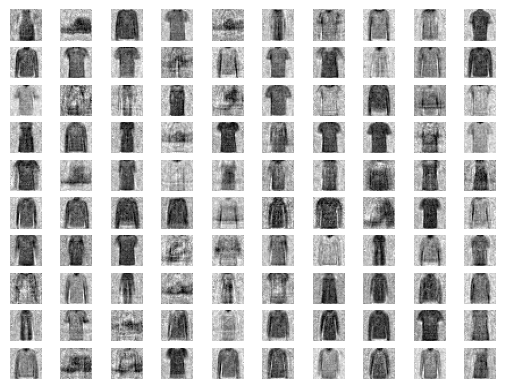

In [33]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

# Generating Samples using GAN

4/4 [==============================] - 0s 4ms/step


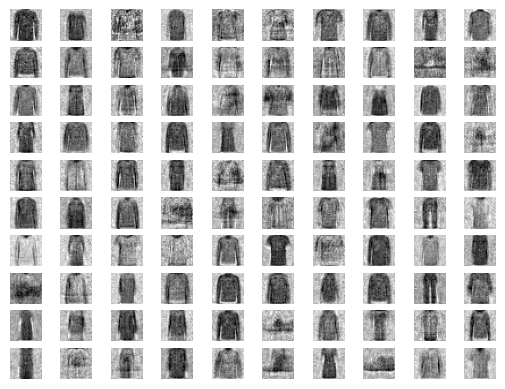

In [38]:
model = load_model('model_18740.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim , n_examples)
X = model.predict(latent_points)
X = (X+1) / 2.0
save_plot(X,n_examples)